<a href="https://colab.research.google.com/github/MansourMhz/MansourMhz/blob/main/30091400_Close_5M.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [117]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch

In [118]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [119]:
dataset = pd.read_csv('/content/drive/MyDrive/MasterThesis/XAUUSD_M5_01.csv')

In [120]:
num_train = int(dataset.shape[0]*0.70)

In [121]:
training_set = dataset.iloc[0:num_train,4].values#Close

In [122]:
testing_set = dataset.iloc[num_train:,4].values#Close

In [123]:
from sklearn.preprocessing import MinMaxScaler

In [124]:
sc = MinMaxScaler(feature_range=(0,1))

In [125]:
training_set_scaled = sc.fit_transform(training_set.reshape(-1,1)) # training

In [126]:
testing_set_scaled = sc.fit_transform(testing_set.reshape(-1,1)) #testing

In [127]:
timestep = 60
X_train =[]
Y_train =[]

In [128]:
for i in range(timestep,len(training_set)):   #Train
    X_train.append(training_set_scaled[i-timestep:i,0]) #
    Y_train.append(training_set_scaled[i,0])

In [129]:
x_train = np.array(X_train)
y_train = np.array(Y_train)

In [130]:
y_train.shape
x_train.shape

(989, 60)

In [131]:
X_train = np.reshape(x_train,(x_train.shape[0], x_train.shape[1],1))

In [132]:
Y_train = np.reshape(y_train,(y_train.shape[0],1))

In [133]:
X_test = []
Y_test =[]

In [134]:
for i in range(timestep,len(testing_set)):    #TEST
    X_test.append(testing_set_scaled[i-timestep:i,0])
    Y_test.append(testing_set_scaled[i,0])

In [135]:
x_test = np.array(X_test)
y_test = np.array(Y_test)

In [136]:
X_test = np.reshape(x_test,(x_test.shape[0], x_test.shape[1],1))
Y_test = np.reshape(y_test,(y_test.shape[0],1))

In [137]:
x_train = torch.from_numpy(X_train).type(torch.Tensor)

In [138]:
y_train = torch.from_numpy(Y_train).type(torch.Tensor)
x_test = torch.from_numpy(X_test).type(torch.Tensor)
y_test = torch.from_numpy(Y_test).type(torch.Tensor)

In [139]:
input_dim = 1 #  60 lstm  1 day
hidden_dim = 30
num_layers = 2
output_dim = 1 # 60 lstm 1 day

In [140]:
class MyLSTM(torch.nn.Module):

    def __init__(self, input_dim, hidden_dim, num_layers,output_dim):
        super(MyLSTM,self).__init__()

        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm = torch.nn.LSTM(input_dim, hidden_dim,num_layers, batch_first = True) #1 -- 32

        self.fc = torch.nn.Linear(hidden_dim, output_dim) #32 --- 1
        self.sf = torch.nn.Sigmoid() #0,1
        #self.sf = torch.nn.ReLU()
        #self.sf = torch.nn.Tanh()

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()   #hidden state matrix zero with grad
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm (x, (h0.detach(),c0.detach()))
        out = self.fc(out[:,-1,:]) # block hidd feature
        out = self.sf(out)

        return out

In [141]:
model = MyLSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)

In [142]:
model

MyLSTM(
  (lstm): LSTM(1, 30, num_layers=2, batch_first=True)
  (fc): Linear(in_features=30, out_features=1, bias=True)
  (sf): Sigmoid()
)

In [143]:
#loss_fn = torch.nn.MSELoss() #l2score l1score #smooth MSE #huber

loss_fn = torch.nn.L1Loss() # best 1
#loss_fn = torch.nn.MSELoss()
#loss_fn = torch.nn.CrossEntropyLoss()
#loss_fn = torch.nn.NLLLoss()
# loss_fn = torch.nn.SmoothL1Loss()

# loss_fn = torch.nn.HuberLoss() # best 2

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

#optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

#optimizer = torch.optim.Adagrad(model.parameters(), lr=0.01)

# optimizer = torch.optim.RMSprop(model.parameters(), lr=0.01)

#train model

In [144]:
num_epoch = 100
listLoss = np.zeros(num_epoch)

In [145]:
for t in range(num_epoch):

    y_train_pred = model(x_train) # forward(self,x) inputs
    loss = loss_fn(y_train_pred , y_train) #loss
    listLoss[t] = loss.item() #save loss in list
    #print("epoch:",t,  "loss", loss.item()) #print lossepoch
    optimizer.zero_grad() #
    loss.backward() #
    optimizer.step() # update

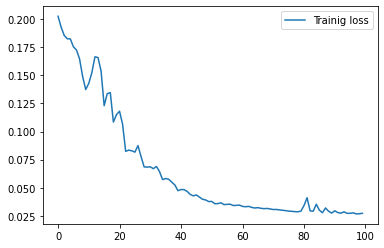

In [146]:
plt.plot(listLoss, label ="Trainig loss")
plt.legend()
plt.show()

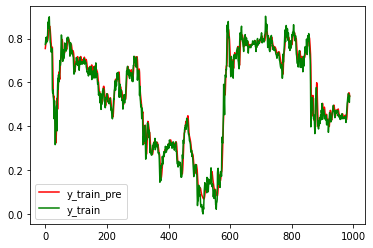

In [147]:
plt.plot(y_train_pred.detach().numpy(), label ="y_train_pre", color ='red')
plt.plot(y_train.detach().numpy(), label ="y_train", color ='green')
plt.legend()
plt.show()

In [148]:
from sklearn.metrics import r2_score

In [149]:
r2_score = r2_score(y_train.detach().numpy(), y_train_pred.detach().numpy())

In [150]:
r2_score

0.9691305457480921

In [151]:
y_test_pred = model(x_test)

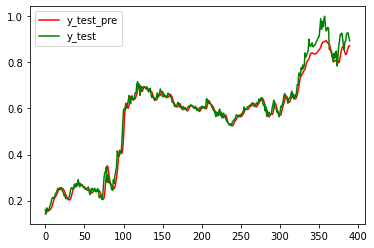

In [152]:
plt.plot(y_test_pred.detach().numpy(), label ="y_test_pre", color ='red')
plt.plot(y_test.detach().numpy(), label ="y_test", color ='green')
plt.legend()
plt.show()

In [153]:
a = y_test_pred.detach().numpy()
b = y_test.detach().numpy()

In [154]:
q1 = a[0:50]
q2 = a[50:100]
q3 = a[100:150]
q4 = a[150:200]
q5 = a[200:250]
q6 = a[250:300]
q7 = a[300:]

In [155]:
w1 = b[0:50]
w2 = b[50:100]
w3 = b[100:150]
w4 = b[150:200]
w5 = b[200:250]
w6 = b[250:300]
w7 = b[300:]

In [156]:
trend = ""
if (q1[0]<q1[len(q1)-1]):
  trend = "positive trend"
else:
  trend = "negative trend"
trend

'positive trend'

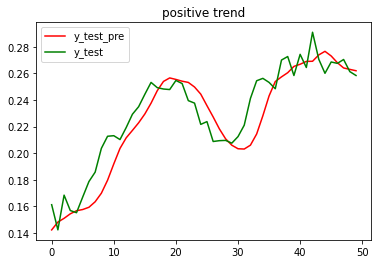

In [157]:
plt.plot(q1, label ="y_test_pre", color ='red')
plt.plot(w1, label ="y_test", color ='green')
plt.title(trend)
plt.legend()
plt.show()

In [158]:
trend = ""
if (q1[0]<q1[len(q1)-1]):
    trend = "positive trend"
else:
  trend = "negative trend"

trend

'positive trend'

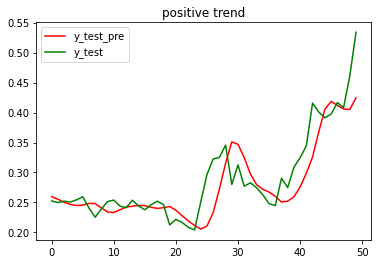

In [159]:
plt.plot(q2, label ="y_test_pre", color ='red')
plt.plot(w2, label ="y_test", color ='green')
plt.title(trend)
plt.legend()
plt.show()

In [160]:
if (q3[0]<q3[len(q3)-1]):
    trend = "positive trend"

else:
    trend = "negative trend"
trend

'positive trend'

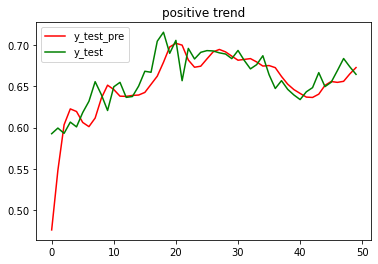

In [161]:
plt.plot(q3, label ="y_test_pre", color ='red')
plt.plot(w3, label ="y_test", color ='green')
plt.title(trend)
plt.legend()
plt.show()

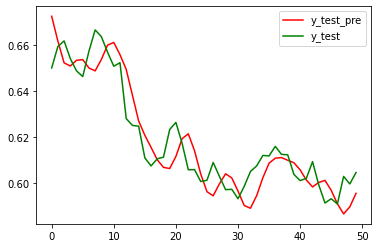

In [162]:
plt.plot(q4, label ="y_test_pre", color ='red')
plt.plot(w4, label ="y_test", color ='green')
plt.legend()
plt.show()

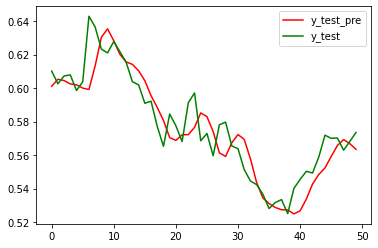

In [163]:
plt.plot(q5, label ="y_test_pre", color ='red')
plt.plot(w5, label ="y_test", color ='green')
plt.legend()
plt.show()


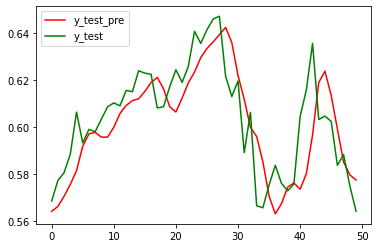

In [164]:
plt.plot(q6, label ="y_test_pre", color ='red')
plt.plot(w6, label ="y_test", color ='green')
plt.legend()
plt.show()

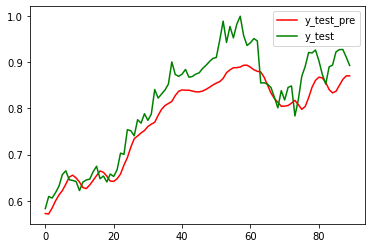

In [165]:
plt.plot(q7, label ="y_test_pre", color ='red')
plt.plot(w7, label ="y_test", color ='green')
plt.legend()
plt.show()

In [166]:
y_test_pred = y_test_pred.detach().numpy()
y_test = y_test.detach().numpy()

In [167]:
import sklearn
r2_score = sklearn.metrics.r2_score(y_test, y_test_pred)
r2_score

0.9801137275363105

In [168]:
from sklearn.metrics import mean_absolute_error, mean_squared_error # Error

In [169]:
mean_absolute_error = mean_absolute_error(y_train.detach().numpy(), y_train_pred.detach().numpy())

In [170]:
mean_absolute_error

0.027252112

In [171]:
mean_squared_error = mean_squared_error(y_train.detach().numpy(), y_train_pred.detach().numpy())

In [172]:
mean_squared_error

0.0014954425

In [173]:
Root_mean_squared_error = np.sqrt(sklearn.metrics.mean_squared_error(y_train.detach().numpy(), y_train_pred.detach().numpy()))

In [174]:
Root_mean_squared_error

0.03867095